In [ ]:
#import library
import os

In [ ]:
# import library for data manipulation
import numpy as np
import pandas as pd

In [ ]:
# import libraries with visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# import sklearn for splitting datset into train and test
from sklearn.model_selection import train_test_split

In [ ]:
# import TensorFlow libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# importing text processing libraries
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# utils libraries
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
# import IMDB dataset
from google.colab import files
files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# DATA CLEANING

Here we will define text cleaning pipeline which consist of several methods below:
1. Remove links
2. Remove punctuations, but here we exclude dot (.), comma (,), hyphen (-), exclamation (!), and question mark(?).
3. Remove HTML tags
4. Space between punctuation, because we want to treat some excluded punctuations as individual token
5. Remove numbers
6. Remove additional whitespaces
7. Remove nonascii characters
8. Remove emoji
9. Label encoding

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
df['clean_review'] = df['review'].progress_apply(clean_pipeline)

100%|██████████| 50000/50000 [00:18<00:00, 2739.35it/s]


In [ ]:
# creating a dummy variable for the sentiment column
df['label'] = np.where(df['sentiment'] == 'positive', 1, 0)

In [ ]:
df.head()

,review,sentiment,clean_review,label,token_length
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production . The filming te...,1,162
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,negative,Basically there s a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei s Love in the Time of Money is a...,1,230


## EDA
1. Transform label into number
2. View data distribution (imbalance or not)
3. View token length distribution
4. Preview on some positive and negative reviews

The sentiment column must be transformed into numeric values so that "positive" sentiment is taken as 1 and "negative" sentiment is taken as 0, in order to create a binary classification model. Using np.where(), I can quickly do this by changing the DataFrame column in pandas:

Let's see if we have an imbalance case by looking at total dataset of each positive and negative classes



In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

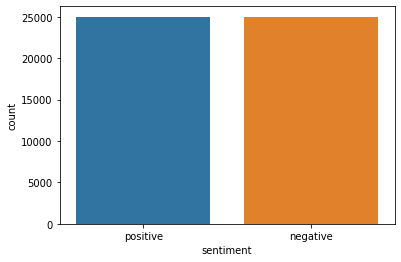

In [ ]:
sns.countplot(x=df["sentiment"]);

Seems we have a good enough dataset. Here we got balance dataset with 25K for each labels.






Now, we want to see token distribution in our dataset. We want to see token distribution for each positive and negative labels. We will split sentences by whitespaces and count total tokens by len() function.

In [ ]:
from tqdm import tqdm # import tqdm
tqdm.pandas()
df['token_length'] = df.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 60193.85it/s]


In [ ]:
filt_pos = df[df['label'] == 1]
filt_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 10. While the average token is 232

In [ ]:
filt_neg = df[df['label'] == 0]
filt_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

And for negative reviews, we have maximum and minimum token respectively 1522 and 4. While the average token is 229.

<Figure size 360x576 with 0 Axes>

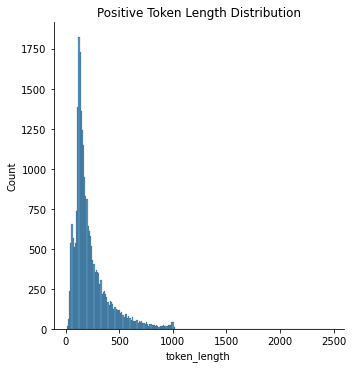

In [ ]:
# Distribution of tokenized negative setiments
plt.figure(figsize=(5, 8))
sns.displot(filt_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show();

<Figure size 360x576 with 0 Axes>

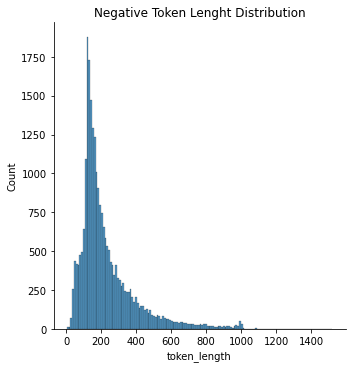

In [ ]:
# Distribution of tokenized negative setiments
plt.figure(figsize=(5, 8))
sns.displot(filt_neg, x='token_length')
plt.title('Negative Token Lenght Distribution')
plt.show();

# XG BOOST

THE PREPROCESSING

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim

In [ ]:
# building a model classification matrix
bow_vectoriser = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 10000, stop_words = 'english')
bow = bow_vectoriser.fit_transform(df['clean_review'])
bow.shape

(50000, 10000)

In [ ]:
# extracting train and test bow features
train_bow = bow[:50000,:]
test_bow = bow[50000:,:]

In [ ]:
# splitting data into test and validation sets
x_train_bow, x_valid_bow, y_train, y_test = train_test_split(train_bow, df['sentiment'], test_size=0.25)

In [ ]:
# XGb Classifier
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(max_depth = 15, n_estimators = 30)

In [ ]:
xgb_model.fit(x_train_bow, y_train)

XGBClassifier(max_depth=15, n_estimators=30)

In [ ]:
xgb_predict = xgb_model.predict(x_valid_bow)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

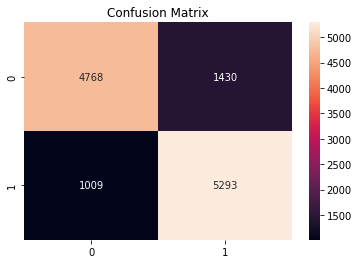

In [ ]:
cm = confusion_matrix(y_test, xgb_predict)
#plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

    negative       0.83      0.77      0.80      6198
    positive       0.79      0.84      0.81      6302

    accuracy                           0.80     12500
   macro avg       0.81      0.80      0.80     12500
weighted avg       0.81      0.80      0.80     12500



# LSTM

THE PREPROCESSING

The reviews and sentiments must then be converted to NumPy arrays because the preprocessing techniques prefer arrays over pandas series:

In [ ]:
# converting the reviews and sentiments to NumPy arrays, since the preprocessing methods favor arrays instead of pandas series
sentences = df['clean_review'].to_numpy()
labels = df['label'].to_numpy()

I must divide our dataset into training and test instances before performing any preprocessing. Seventy Five percent of the data will be used for training, and twenty five percent for testing as seen in he line of code below

In [ ]:
# splitting the dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25)

I must translate text data (reviews) into numeric values in order to construct a mathematical model.  This is called  Tokenization, and this is done on the complete text corpus, which includes all training data, for the majority of NLP projects.

Sentences are divided into a collection of individual words during the tokenization process, and statistical characteristics are computed for each word, including:
-word counts: Defines the vocabulary that is currently present in the corpus of text. The number of times a word appears in the text corpus is linked to each individual term
-Words in the text corpus are represented by word docs, which is a dictionary. Each term in the text corpus has a corresponding number of sentences that contain it.
-Each term in the word dictionary has a specific index, which is called word index.
-document count: Indicates how many sentences (documents) there are in the corpus of text.

I must define the vocabulary size in order to tokenize the training data.vocabulary size is the total number of words that may be obtained by ranking each word's frequency of use from lowest to highest.

In this case, I only use the first 10,000 words that appear in the training dataset. Additionally, I have set oov_tok to "< OOV >," which will substitute for any unidentified words in the corpus of text.

In [ ]:
# tokenizing the textual words
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

After defining the hyperparameters for Tokenizer(), I use fit on texts() to fit it into the training data:

In [ ]:
# fitting the tokenized hyperparameters to the training data
tokenizer.fit_on_texts(x_train)

After the text corpus has been tokenized, I used the tokenizer to change each review to a numeric sequence:

In [ ]:
# converting each review into a numeric sequence using the tokenizer
train_sequences = tokenizer.texts_to_sequences(x_train)

With the objective of training the mathematical model, each review of the training data is transformed into a numerical sequence.
Each review's content, however, has a varied word length, which will result in varying lengths for the numeric sequence compared to other reviews.
Therefore, I must restrict the sequence lengths for each review to a fixed value. For each review, I will establish a sequence length of 200 words.
The end of numerical sequences longer than 200 will be truncated, whereas the end of sequences less than 200 will be padded with zeros.

For numeric sequences in reviews, I now defined a sequence padding.

In [ ]:
# specifying a sequence length of 200 words for each review
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')

After pre-processing the training data, I must follow the identical procedures for the test data:

In [ ]:
# repeating the above process for the test data
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

## 2. LSTM Model for Sentiment Analysis


I have completed the review preparation steps of padding, sequence conversion, and tokenization.
I will now proceed with creating the sentiment analysis LSTM model.

In [ ]:
# declearing the model type
model = Sequential()

I will start by adding an embedding layer, which will transform each word into a dense vector with embedding dimensions determined by the layer's hyperparameters:

In [ ]:
# adding an embedding layer
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

Next, I will define the LSTM layer with a chosen unit size and the Bidirectional() layer.

The fact that bi-directional LSTM recalls the output from the past to the future as well as from the future to the past is one of its benefits. For time series analysis, this method may produce more reliable models.

In [ ]:
# defining the LSTM layer with a chosen unit size
lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))

I will then add an output layer with only one unit and a "sigmoid" activation after specifying a fully linked layer with 10 units and a "relu" activation. This layer will show the likelihood that a given input falls to category 1. (or positive).

In [ ]:
# adding an output layer
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________
None


I now compile the model and show its summary:

In [ ]:
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Assuming I defined 5 epochs and our model converged to minimum validation loss after only 2. The model will likely get overfit to the training data during the final 3 epochs.

I prevented this by supplying the EarlyStopping() callback, which will halt model training if the model is unable to reduce the validation loss value after the callback's given number of epochs.




In [ ]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [ ]:
history = model.fit(train_padded, y_train, epochs=5, validation_data=(test_padded, y_test), callbacks=callbacks)

Epoch 1/5
1172/1172 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8095

1172/1172 [==============================] - 174s 145ms/step - loss: 0.4110 - accuracy: 0.8095 - val_loss: 0.3266 - val_accuracy: 0.8570
Epoch 2/5
1172/1172 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8961

1172/1172 [==============================] - 172s 146ms/step - loss: 0.2675 - accuracy: 0.8961 - val_loss: 0.3032 - val_accuracy: 0.8760
Epoch 3/5
1172/1172 [==============================] - 156s 133ms/step - loss: 0.2208 - accuracy: 0.9154 - val_loss: 0.3740 - val_accuracy: 0.8690
Epoch 4/5
1172/1172 [==============================] - 164s 140ms/step - loss: 0.1920 - accuracy: 0.9285 - val_loss: 0.3670 - val_accuracy: 0.8667


In [ ]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.411022  0.809467  0.326637       0.85704
1  0.267453  0.896053  0.303200       0.87600
2  0.220819  0.915413  0.374032       0.86896
3  0.191983  0.928533  0.367019       0.86672


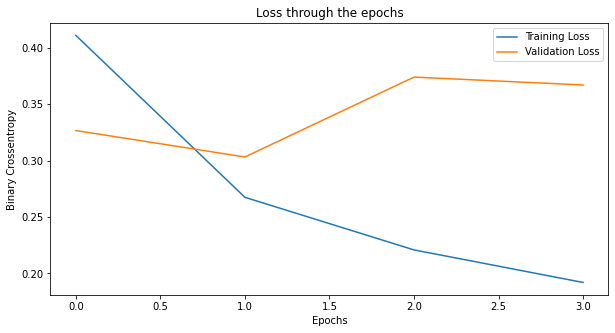

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Loss through the epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

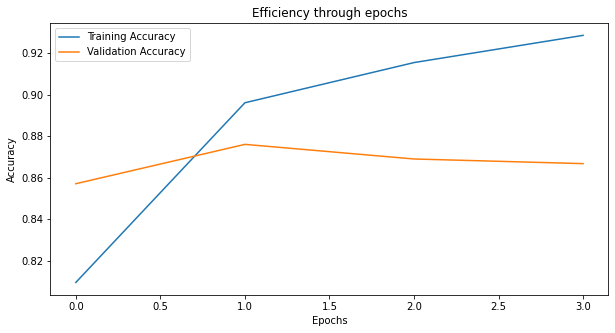

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title("Efficiency through epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
sentences =["i loved it! highly recommend it to anyone and everyone looking for a great movie to watch.",
            "I thought this was a wonderful way to spend time"]

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=sequence_length, padding='post', truncating='post')
print (model.predict(padded))


1/1 [==============================] - 0s 37ms/step
[[0.9729676 ]
 [0.84732777]]
